In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [Why Most Published Research Findings Are False](http://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0020124) John Ioannidis argues that if most hypotheses we test are false, we end up with more false research findings than true findings, even if we do rigorous hypothesis testing.  The argument hinges on a vanilla application of Bayes' rule. Lets assume that science is "really hard" and that only 50 out of 1000 hypotheses we formulate are in fact true. Say we test our hypotheses at significance level alpha=0.05 and with power beta=0.80. Out of our 950 incorrect hypotheses, our hypothesis testing will lead to 950x0.05 = 47.5 false positives i.e. false research findings. Out of our 100 correct hypotheses, we will correctly identify 50x0.8 = 40 true research findings. To our horror, we find that most published findings are false!

Most applications of AB testing involve running multiple repeated experiments in order to optimize a metric. At each iteration, we test a hypothesis: Does the new design perform better than the control? If so, we adopt the new design as our control and test the next idea. After many iterations, we expect to have a design that is better than when we started. But Ioannidis' argument about how most research findings could be false should make us wonder:

- Is it possible, that if the chances of generating a better new design are slim, that we adopt bad designs more often than we adopt good designs? What effect does this have on our performance in the long run?
- How can we change our testing strategy in such a way that we still expect to increase performance over time? Conversely, how can we take advantage of a situation where the chances of generating a design that is better than the control is really high?


To investigate these questions, lets simulate the process of repeated AB testing for optimizing some conversion rate (CR) under different scenarios for how hard our optimization problem is. For example, our CR could be the fraction of users who donate to Wikipedia in response to being shown a particular fundraising banner. I will model the difficulty of the problem using a distribution over the percent lift in conversion rate (CR) that a new idea has over the control. In practice we might expect the mean of this distribution to change with time.  As we work on a problem longer, the average idea probably gives a smaller performance increase. For our purposes, I will assume this distribution  (call it $I$) is fixed and normally distributed.

We start with a control banner with some fixed conversion rate (CR). At each iteration, we test the control against a new banner whose percent lift over the control is drawn from $I$. If the new banner wins, it becomes the new control. We repeat this step several times to see what final the CR is after running a sequence of tests. I will refer to a single sequence of tests as a campaign. We can simulate several campaigns to characterize  the distribution of outcomes  we can expect at the end of a campaign.

## Code

For those who are interested, this section describes the simulation code. The `Test` class, simulates running a single AB test.  The parameters `significance`, `power` and `mde` correspond to the significance, power and minimum effect size of the z-test used to test the hypothesis that the new design and the control have the same CR. The `optimistic` parameter determines which banner we choose if we fail to reject the null hypothesis that the two designs are the same.

In [17]:
import numpy as np
np.random.seed(seed=0)
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import bernoulli

class Test():
    
    def __init__(self, significance, power, mde, optimistic):
        self.significance = significance
        self.power = power
        self.mde = mde
        self.optimistic = optimistic
        
    def compute_sample_size(self, u_hat):
        var_hat = u_hat*(1-u_hat)
        absolute_effect = u_hat - (u_hat*(1+self.mde))
        standardized_effect = absolute_effect / np.sqrt(var_hat)
        sample_size = tt_ind_solve_power(effect_size=standardized_effect,
                                         alpha=self.significance,
                                         power=self.power)
        return sample_size
    
    def run(self, control_cr, treatment_cr):

        # run null hypothesis test with a fixed sample size
        N = self.compute_sample_size(control_cr)
        data_control = bernoulli.rvs(control_cr,size=N)
        data_treatment = bernoulli.rvs(treatment_cr,size=N)
        p = ztest(data_control, data_treatment)[1]

        # if p > alpha, no clear winner
        if p > self.significance:
            if self.optimistic:
                return treatment_cr
            else:
                return  control_cr 

        # other wise pick the winner
        else:
            if data_control.sum() > data_treatment.sum():
                return control_cr
            else:
                return treatment_cr
    

The `Campaign` class simulates running `num_tests` AB tests, starting with a `base_rate` CR. The parameters `mu` and `sigma` characterize $I$, the distribution over the percent gain in performance of a new design compared to the control.

In [18]:
class Campaign():
    
    def __init__(self, base_rate, num_tests, test, mu, sigma):
        
        self.num_tests = num_tests
        self.test = test
        self.mu = mu
        self.sigma = sigma
        self.base_rate = base_rate
        
        
    def run(self):
        
        true_rates = [self.base_rate,]
        for i in range(self.num_tests):
            #the control of the current test is the winner of the last test
            control_cr = true_rates[-1]
            # create treatment banner with a lift drawn from the lift distribution
            lift = np.random.normal(self.mu, self.sigma)
            treatment_cr = min(0.9, control_cr*(1.0+lift/100.0))
            winning_cr = self.test.run(control_cr, treatment_cr)
            true_rates.append (winning_cr)
       
        return true_rates

The `expected_campaign_results` function implements running many campaigns with the same starting conditions. It generates a plot depicting the expected CR as a function of the number of sequential AB test.

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def expected_campaign_results(campaign, sim_runs):
    fig = plt.figure(figsize=(10, 6), dpi=80)
    
    d = pd.DataFrame()
    for i in range(sim_runs):
        d[i] = campaign.run()
        
    d2 = pd.DataFrame()
    d2['mean'] = d.mean(axis=1)
    d2['lower'] = d2['mean'] + 2*d.std(axis=1)
    d2['upper'] = d2['mean'] - 2*d.std(axis=1)
    
    plt.plot(d2.index, d2['mean'], label= 'CR')
    plt.fill_between(d2.index, d2['lower'], d2['upper'], alpha=0.31,
                     edgecolor='#3F7F4C', facecolor='0.75',linewidth=0)
    
    plt.xlabel('num tests')
    plt.ylabel('CR')
    
    plt.plot(d2.index, [base_rate]*(num_tests+1), label = 'Start CR')
    plt.legend()   

## Simulations


I will start out with a moderately pessimistic scenario and assume the average new design is 5% worse than the control and that standard deviation `sigma` is 3. The plot below shows the distribution over percent gains from new designs.

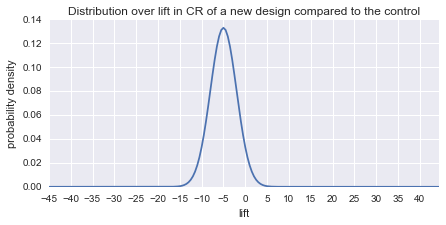

In [20]:
def plot_improvements(mu, sigma):
    plt.figure(figsize = (7, 3))
    x = np.arange(-45.0, 45.0, 0.5)
    plt.xticks(np.arange(-45.0, 45.0, 5))
    plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma**2) ))
    plt.xlabel('lift')
    plt.ylabel('probability density')
    plt.title('Distribution over lift in CR of a new design compared to the control')

#Distribution over % Improvements
mu = -5.0
sigma = 3

plot_improvements(mu, sigma)

Lets start out with some standard values of `alpha` = 0.05, `beta` = 0.8 and `mde` = 0.10 for the hypothesis tests. The plot below shows the expected CR after a simulating a sequence of 30 AB tests 100 times.

In [21]:
# hypothesis test params
significance = 0.05
power = 0.8
mde = 0.10

#camapign params
num_tests = 30
base_rate = 0.2

#number of trials
sim_runs = 100

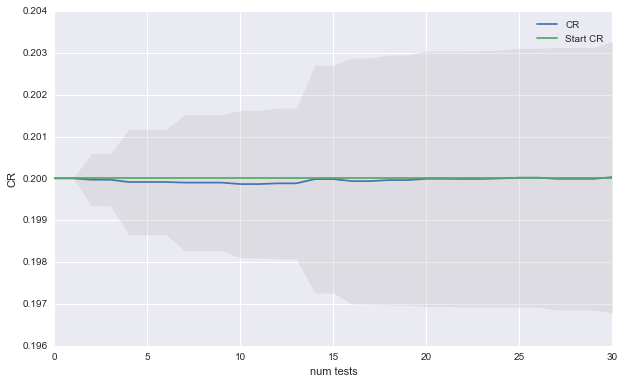

In [22]:
test = Test(significance, power, mde, optimistic = False)
campaign = Campaign(base_rate, num_tests, test, mu, sigma)
expected_campaign_results(campaign, sim_runs)

Even though we went through all work of running 100 AB test, we cannot expect to improve our CR. The good news is that although most of our ideas were bad, doing the AB testing prevented us from loosing performance. The plot below shows what would happen if we had used the new idea as the control when the hypothesis test could not discern a significant difference.

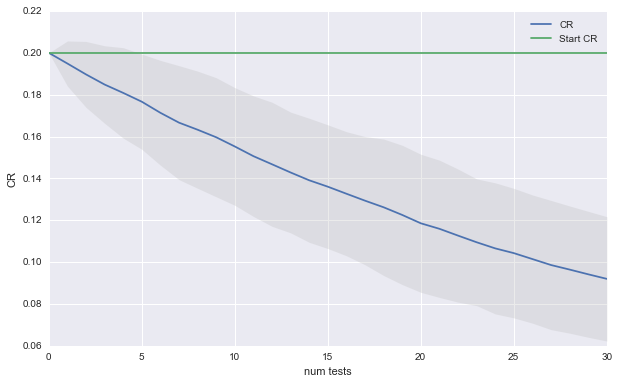

In [23]:
test = Test(significance, power, mde, optimistic = True)
campaign = Campaign(base_rate, num_tests, test, mu, sigma)
expected_campaign_results(campaign, sim_runs)

Impressive. The CR starts tanking at a rapid pace. This is an extreme example but it spells out a clear warning: if your optimization problem is hard, stick to your control.

Now lets imagine a world in which most ideas are neutral but there is still the potential for big wins and big losses. The plot below shows our new distribution over the quality of new ideas.

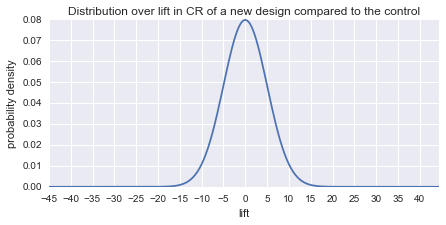

In [24]:
mu = 0.0
sigma = 5

plot_improvements(mu, sigma)

And here are the result of the new simulation:

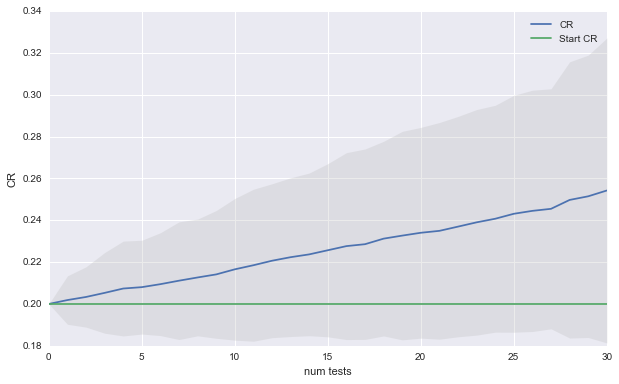

In [25]:
test = Test(significance, power, mde, optimistic = False)
campaign = Campaign(base_rate, num_tests, test, mu, sigma)
expected_campaign_results(campaign, sim_runs)

Now there is huge variance in how things could turn out. In expectation, we get a 2% absolute gain every 10 tests. As you might have guessed, in this scenario it does not matter which banner you choose when the hypothesis test does not detect a significant difference. 

Lets see if we can reduce the variance in outcomes by decreasing the minimum detectable effect `mde` to 0.05. This will cost us in terms of runtime for each test, but it also should reduce the variance in the expected results.

In [26]:
mde = 0.05

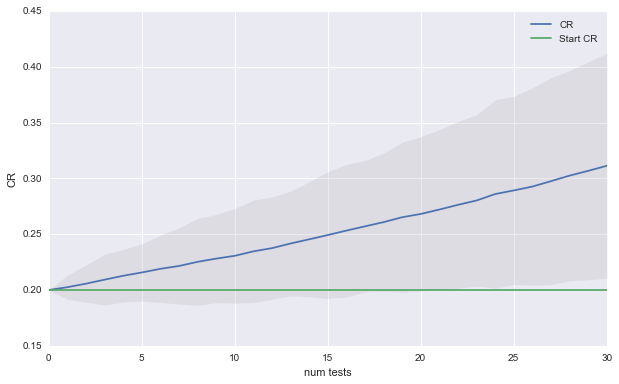

In [27]:
test = Test(significance, power, mde, optimistic = False)
campaign = Campaign(base_rate, num_tests, test, mu, sigma)
expected_campaign_results(campaign, sim_runs)

Now we can expect 5% absolute gain every 15 tests. Furthermore, it is very unlikely that we have not improved out CR after 30 tests.

Finally, lets consider the rosy scenario in which most new ideas are a winner. 

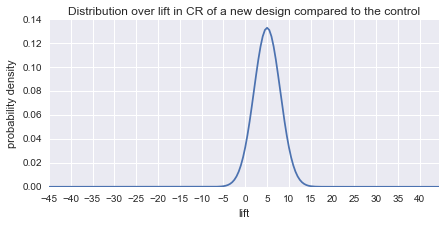

In [28]:
mu = 5
sigma = 3
plot_improvements(mu, sigma)

Again, here are the result of the new simulation:

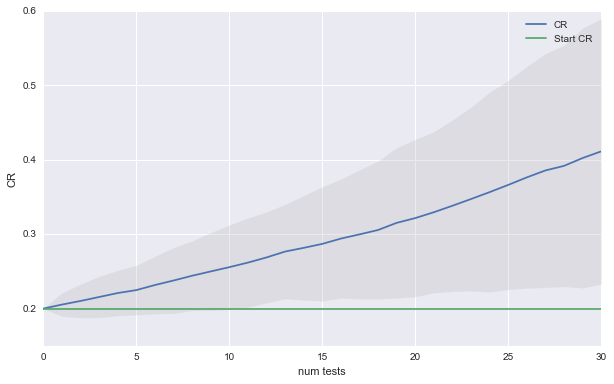

In [29]:
mde = 0.10
test = Test(significance, power, mde, optimistic = False)
campaign = Campaign(base_rate, num_tests, test, mu, sigma)
expected_campaign_results(campaign, sim_runs)

Having good ideas is a recipe for runaway success. You might even decide that its foolish to choose the control banner when you don't have significance since chances are that your new idea is better, even if you could not detect it. The plot below shows that choosing the new idea over the control leads to even faster growth in performance.

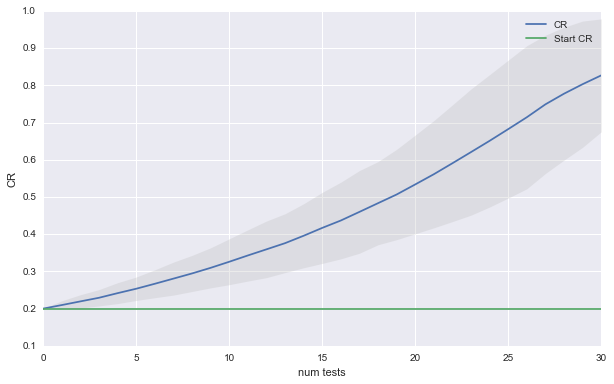

In [30]:
test = Test(significance, power, mde, optimistic = True)
campaign = Campaign(base_rate, num_tests, test, mu, sigma)
expected_campaign_results(campaign, sim_runs)

## Lessons Learned

I hope these simulations provide some insight into the possible long term outcomes AB testing can achieve. Not surprisingly, whether you will be successful in increasing your performance metric has everything to do with the quality of your new designs. Even if your optimization problem is hard, however,  AB testing can give you ability to safely explore new ideas as long as you stick to your control in times of doubt. 

When most of your ideas have a neutral effect, AB testing helps you pick out the better ideas in expectation. As a result, performance does not simply oscillate around the starting point, but steadily increases. 

If you are in the lucky position that your design team cannot miss, you are bound to succeed, whether you test or not. However, running AB tests will protect you from adopting a rare failed design. If you are in a hurry to boost your metric, you might consider going with the new design when results are ambiguous. 

The results also suggest that it would be immensely useful to know which of these 3 scenarios most closely resembles your own. If your optimization problem is hard, you might decide that designing further iterations is not worth the effort. If there is the possibility of large gains and losses, you might decide to run your tests longer, to decrease the variance in possible future outcomes. 

If you have already run a series of tests, you could gauge where you stand by looking at the distribution over the empirical gains of your new designs. For example, in the first simulation, gains are normally distributed with mean -5 and standard error 3. Lets assume that the true distribution over gains is also normally distributed. You could use the observed empirical gains to estimate the mean and standard error of the true lift distribution. 

Note: You could also consider switching from the standard z-test, to a Bayesian test and use the results of past tests to set an appropriate prior. 